In [1]:
# Install spaCy (if not already installed)
!pip install spacy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Install pandas and scikit-learn for data handling and evaluation
!pip install pandas scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Install nltk for advanced preprocessing
!pip install nltk wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import spacy
from spacy.pipeline.textcat import Config, single_label_bow_config
from spacy.training import Example
from spacy.util import minibatch, compounding
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [19]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Load train.csv
train_data = pd.read_csv("train.csv")

# Display the first few rows to understand the structure
train_data.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Check for missing values and overall dataset structure
# print("Missing values in the dataset:")
# print(train_data.isnull().sum())
# train_data.info()
# train_data.describe()

In [21]:
# Keep only the 'toxic' label for single-label classification
train_data = train_data[['id', 'comment_text', 'toxic']]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            159571 non-null  object
 1   comment_text  159571 non-null  object
 2   toxic         159571 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [22]:
# **EDA Section**
print("### Exploratory Data Analysis (EDA) ###")
# Dataset overview
print(f"Dataset Shape: {train_data.shape}")
print(train_data.info())
print(train_data.describe(include="all"))

### Exploratory Data Analysis (EDA) ###
Dataset Shape: (159571, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            159571 non-null  object
 1   comment_text  159571 non-null  object
 2   toxic         159571 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.7+ MB
None
                      id                                       comment_text  \
count             159571                                             159571   
unique            159571                                             159571   
top     fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   
freq                   1                                                  1   
mean                 NaN                                                NaN   
std                  NaN                                                NaN   


In [23]:
# Define input (comments) and output (labels)
X = train_data['comment_text']
y = train_data['toxic']  # Single label for toxicity

# Inspect label distribution
print("Label distribution:")
print(y.value_counts())  # Check class counts

# Split the data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Label distribution:
toxic
0    144277
1     15294
Name: count, dtype: int64
Training samples: 127656, Validation samples: 31915


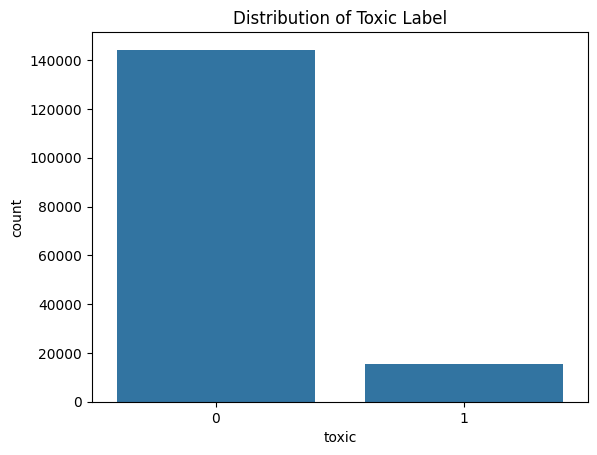

In [24]:
# Distribution of 'toxic' label
sns.countplot(x='toxic', data=train_data)
plt.title('Distribution of Toxic Label')
plt.show()

In [25]:
# Define input (comments) and output (labels)
X = train_data['comment_text']
y = train_data['toxic']  # Single label for toxicity

# Inspect label distribution
print("Label distribution:")
print(y.value_counts())  # Check class counts

Label distribution:
toxic
0    144277
1     15294
Name: count, dtype: int64


Test 1: Undersampling

Before undersampling: Non-toxic = 144277, Toxic = 15294
After undersampling: Non-toxic = 15294, Toxic = 15294


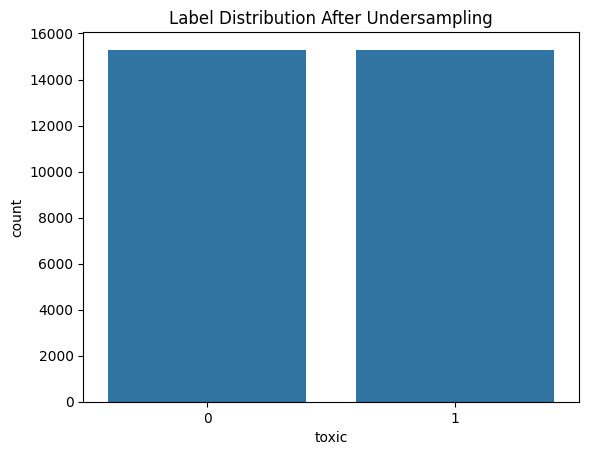

In [26]:
# Separate toxic and non-toxic samples
toxic = train_data[train_data['toxic'] == 1]
non_toxic = train_data[train_data['toxic'] == 0]

# Display the number of samples in each class before undersampling
print(f"Before undersampling: Non-toxic = {len(non_toxic)}, Toxic = {len(toxic)}")

# Undersample non-toxic class to match the number of toxic samples
non_toxic_undersampled = non_toxic.sample(len(toxic), random_state=42)

# Combine undersampled non-toxic samples with toxic samples
balanced_data = pd.concat([toxic, non_toxic_undersampled], axis=0)

# Shuffle the combined dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the number of samples in each class after undersampling
print(f"After undersampling: Non-toxic = {balanced_data['toxic'].value_counts()[0]}, Toxic = {balanced_data['toxic'].value_counts()[1]}")

# Verify label distribution
sns.countplot(x='toxic', data=balanced_data)
plt.title('Label Distribution After Undersampling')
plt.show()

In [27]:
# Define input and output for balanced dataset
X_balanced = balanced_data['comment_text']
y_balanced = balanced_data['toxic']

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 24470, Validation samples: 6118


In [28]:
# Function to transform the data into spaCy format
def prepare_spacy_data(comments, labels):
    spacy_data = []
    for comment, label in zip(comments, labels.values):
        # Create a dictionary of labels with their binary values
        cats = {"toxic": bool(label), "non_toxic": not bool(label)}
        spacy_data.append((comment, {'cats': cats}))
    return spacy_data

# Prepare training and validation data
train_data_spacy = prepare_spacy_data(X_train, y_train)
val_data_spacy = prepare_spacy_data(X_val, y_val)

# Print a sample of the processed data
print("Sample processed data (spaCy format):")
print(train_data_spacy[:3])

Sample processed data (spaCy format):
[("Douche bag, know the band Sublime before you tell me that i did something wrong\nit clearly is stated in many interviews and even in their documentary that Miguel Happoldt did everything that the band members didn't know.\n\nknow your shit", {'cats': {'toxic': True, 'non_toxic': False}}), ('we will find out who you are and you will be exposed as a Wiki Cultist loser you filth66.77.102.10', {'cats': {'toxic': True, 'non_toxic': False}}), ('do not tell me to delete stuff you stinker!!!!!!!!!!!!!!!!!!!!!!!!!', {'cats': {'toxic': True, 'non_toxic': False}})]


In [ ]:
# Function to clean text
# def preprocess_text(text):
#     text = text.lower()  # Convert to lowercase
#     text = re.sub(r"\s+", " ", text)  # Remove extra whitespaces
#     text = re.sub(r"http\S+", "", text)  # Remove URLs
#     text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
#     return text

# # Apply preprocessing to training and validation data
# X_train_cleaned = X_train.apply(preprocess_text)
# X_val_cleaned = X_val.apply(preprocess_text)

# # Prepare spaCy data again with cleaned text
# train_data_spacy = prepare_spacy_data(X_train_cleaned, y_train)
# val_data_spacy = prepare_spacy_data(X_val_cleaned, y_val)

# print("Sample cleaned data (spaCy format):")
# print(train_data_spacy[:3])

In [29]:
# **Enhanced Preprocessing using NLTK**
def preprocess_text_nltk(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespaces
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply enhanced preprocessing to training and validation data
X_train_cleaned = X_train.apply(preprocess_text_nltk)
X_val_cleaned = X_val.apply(preprocess_text_nltk)

# Prepare spaCy data again with cleaned text
train_data_spacy = prepare_spacy_data(X_train_cleaned, y_train)
val_data_spacy = prepare_spacy_data(X_val_cleaned, y_val)

print("Sample cleaned data (spaCy format):")
print(train_data_spacy[:3])

Sample cleaned data (spaCy format):
[('douche bag know band sublime tell something wrong clearly stated many interview even documentary miguel happoldt everything band member didnt know know shit', {'cats': {'toxic': True, 'non_toxic': False}}), ('find exposed wiki cultist loser filth667710210', {'cats': {'toxic': True, 'non_toxic': False}}), ('tell delete stuff stinker', {'cats': {'toxic': True, 'non_toxic': False}})]


In [ ]:
# Save processed data to files (optional)
# import json

# with open("train_data_spacy.json", "w") as f:
#     json.dump(train_data_spacy, f)

# with open("val_data_spacy.json", "w") as f:
#     json.dump(val_data_spacy, f)

# print("Preprocessed data saved as JSON files.")

In [30]:
# Create a blank spaCy pipeline for English
nlp = spacy.blank("en")

# Print a confirmation
print("Blank spaCy pipeline created.")


Blank spaCy pipeline created.


In [31]:
config = Config().from_str(single_label_bow_config)
textcat = nlp.add_pipe("textcat", config=config, last=True)

# Add the 2 oposit labels to the text categorizer
textcat.add_label("toxic")
textcat.add_label("non_toxic")

analysis = nlp.analyze_pipes(pretty=True)
print(analysis)


============================= Pipeline Overview =============================

#   Component   Assigns    Requires   Scores            Retokenizes
-   ---------   --------   --------   ---------------   -----------
0   textcat     doc.cats              cats_score        False      
                                      cats_score_desc              
                                      cats_micro_p                 
                                      cats_micro_r                 
                                      cats_micro_f                 
                                      cats_macro_p                 
                                      cats_macro_r                 
                                      cats_macro_f                 
                                      cats_macro_auc               
                                      cats_f_per_type              

✔ No problems found.
{'summary': {'textcat': {'assigns': ['doc.cats'], 'requires': [], 'scores': ['cats

In [32]:
# Initialize optimizer
optimizer = nlp.begin_training()

# Training parameters
n_iter = 10  # Number of iterations

In [33]:
# Training loop
for epoch in range(n_iter):
    random.shuffle(train_data_spacy)  # Shuffle training data each epoch
    losses = {}
    
    # Create batches of data
    batches = minibatch(train_data_spacy, size=compounding(4.0, 32.0, 1.001))
    
    for batch in batches:
        examples = []
        for text, annotations in batch:
            # Create Example objects
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, {"cats": annotations["cats"]})  # Single-label format
            examples.append(example)
        
        # Update the model with the batch of Example objects
        nlp.update(examples, drop=0.5, losses=losses)
    
    print(f"Epoch {epoch + 1}, Loss: {losses['textcat']}")

Epoch 1, Loss: 250.42579345032573
Epoch 2, Loss: 119.75880854335264
Epoch 3, Loss: 85.00443466786157
Epoch 4, Loss: 64.42815194962239
Epoch 5, Loss: 51.3584025508992
Epoch 6, Loss: 42.96566174618516
Epoch 7, Loss: 37.78979516665863
Epoch 8, Loss: 34.08401134723604
Epoch 9, Loss: 29.022310743734163
Epoch 10, Loss: 26.424752437443345


In [34]:
# Collect predictions and true labels
true_labels = []
pred_labels = []

for text, annotations in val_data_spacy:  # val_data is a list of (text, annotations)
    # Convert the text and annotations into an Example
    example = spacy.training.Example.from_dict(nlp.make_doc(text), {"cats": annotations["cats"]})
    
    # Process the text with the model
    doc = nlp(example.text)
    
    # Collect the predictions
    pred_labels.append({label: doc.cats[label] for label in doc.cats})
    
    # Collect the true labels
    true_labels.append(annotations["cats"])

# Convert predictions to binary based on threshold
threshold = 0.5
pred_binary = [
    {label: int(score >= threshold) for label, score in pred.items()}
    for pred in pred_labels
]

# Extract the keys (categories/labels) in a consistent order
categories = list(true_labels[0].keys())

# Convert dictionaries to 2D arrays for sklearn
true_array = np.array([[label_dict[cat] for cat in categories] for label_dict in true_labels])
pred_array = np.array([[label_dict[cat] for cat in categories] for label_dict in pred_binary])

# Evaluate using sklearn's classification report
print(classification_report(true_array, pred_array, target_names=categories))

              precision    recall  f1-score   support

       toxic       0.91      0.88      0.90      3079
   non_toxic       0.89      0.91      0.90      3039

   micro avg       0.90      0.90      0.90      6118
   macro avg       0.90      0.90      0.90      6118
weighted avg       0.90      0.90      0.90      6118
 samples avg       0.90      0.90      0.90      6118

